In [2]:
import numpy as np

from IPython.display import Image, display


# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../') # Add the course directory to the Python path
import cphy.plotting as cplot



# Microscopy data and deconvolution methods

Many microscopy techniques are based on the detection of light emitted by fluorescent molecules. The light emitted by a single molecule is very weak and cannot be detected directly. Instead, the sample is illuminated with a strong light source, and the light emitted by the molecules is detected by a camera. 

The image obtained in this way is a convolution of the true image with the point spread function (PSF) of the microscope. The PSF is the image of a single molecule under the microscope, and it can often be calculated experimentally or inferred from the optical design imaging setup. Mathematically, the observed image has the form of a convolution between the true image and the PSF:

$$
\begin{align}
I_{obs}(x,y) &= (I_{true} * PSF)(x,y) \\
&= \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} I_{true}(x',y') PSF(x-x',y-y') dx' dy'
\end{align}
$$

Note the similarity between this equation and the Green's function of a physical system.

In order to increase the  effective resolution of the microscope, it is necessary to deconvolve the image with the PSF. This is an ill-posed problem, because there are many different methods for solving it.

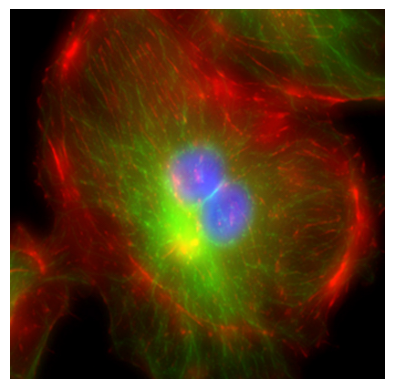

In [3]:
fpath = "../resources/fluorescence_image.npy"
im = np.load(fpath, allow_pickle=True)

plt.imshow(im)
cplot.vanish_axes()


In [4]:
## Deconvolve the image

import scipy.fftpack# import fft2, ifft2, fftshift, ifftshift

from scipy.signal import convolve2d

def gaussian_kernel(size: int, sigma: float):
    kernel = np.fromfunction(
        lambda x, y: (1/ (2 * np.pi * sigma**2)) * 
                     np.exp(- ((x - (size - 1) / 2) ** 2 + (y - (size - 1) / 2) ** 2) / (2 * sigma**2)),
        (size, size)
    )
    return kernel / np.sum(kernel)

def richardson_lucy(image, sigma=1, iterations=50):

    image = image.astype(np.float64) #/ np.max(image)

    psf = gaussian_kernel(3, sigma)

    estimate = np.copy(image)
    for i in range(iterations):
        q = image / (1e-8 +convolve2d(estimate, psf, 'same'))
        estimate *= convolve2d(q, psf[::-1, ::-1], 'same')
    return estimate.T


all_channels = []
for i in range(3):
    channel = richardson_lucy(im[..., i])
    channel = 255 * channel / np.max(channel)
    all_channels.append(channel)
restored_image = np.array(all_channels).T
restored_image = restored_image.astype(np.uint8)


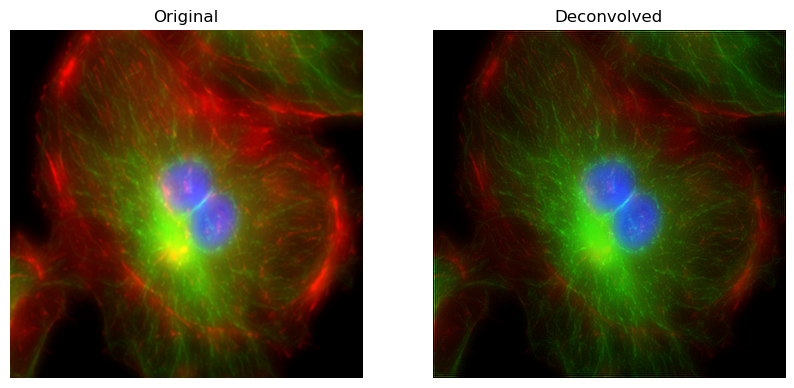

In [131]:
# Show image a and restored side-by-side

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(im)
plt.title("Original")
cplot.vanish_axes()

plt.subplot(122)
plt.imshow(restored_image)
plt.title("Deconvolved")
cplot.vanish_axes()

Text(0.5, 1.0, 'Deconvolved')

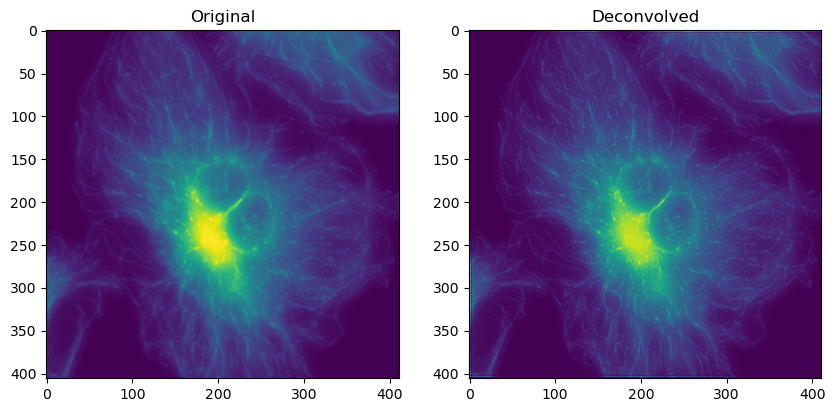

In [134]:
# Compare just green channel to highlight what changed
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(im[..., 1])
plt.title("Original")
plt.subplot(122)
plt.imshow(restored_image[..., 1])
plt.title("Deconvolved")

## Superresolution: inferring latent structure from low-resolution observations



# Models with latent variables

+ Gaussian mixture models(unsupervised model)
+ Clustering (unsupervised)
+ Unsupervised learning: we want to learn the underlying structure of the data


## Bayes' Theorem and Maximum-Likelihood


If $X$ denotes our observed data, and $\theta$ denotes the parameters of our model of the data's generating process,
$$
p(X | \theta)\, p(\theta) = p(\theta |X)\, p(X)
$$
The individual terms in Bayes' theorem have distinct interpretations. 

+ The distribution over model parameters, $p(\theta)$, represents the *prior*; in the absence of any observed data, the prior tells us our expectation regarding the model values. This distribution might incorporate domain knowledge or previous fitted models.
+  The distribution $p(X)$ represents the distribution of observable data, which depends on factors external to the model.
+  The conditional probability $p(\theta | X)$ represents the *posterior* of the model: given our observations, $X$, the posterior determines the probability of different models. 
+ The conditional probability $p(X | \theta)$ represents the *likelihood*, which is the probability of having observed a given set of observations $X$ given a specific model with parameters $\theta$. 

Many classes of algorithms attempt to determine $\theta$ through *maximumum likelihood methods,* which attempt to find the model $\theta$ that maximizes the probability of the observed dats $X$.


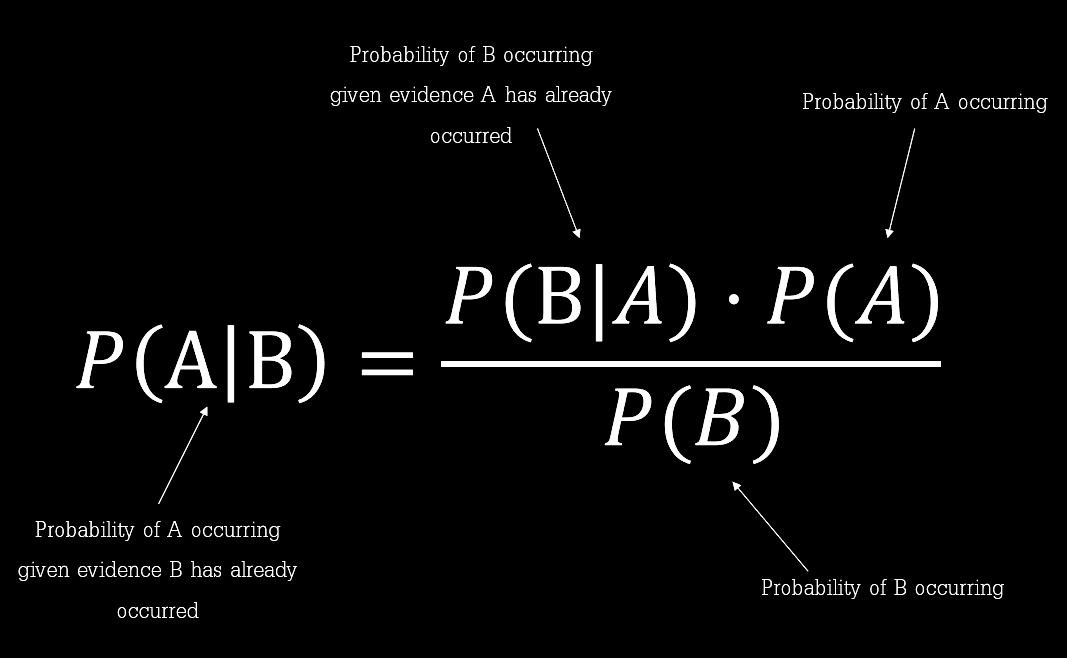

In [ ]:
Image("../resources/bayes.png", width=600)
# https://thestatsninja.com/2019/03/03/how-to-decipher-false-positives-and-negatives-with-bayes-theorem/

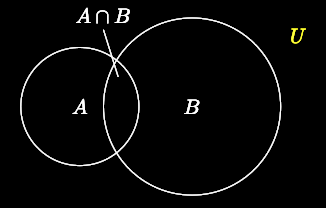

In [ ]:
# show two images
Image("../resources/bayes_overlap.png", width=600)
# https://towardsdatascience.com/3-ways-to-think-about-bayes-rule-b6f5b4ef87d6

## EM algorithm

+ For learning generative models with latent variables in cases where we don't have gradient information to perform traditional optimization. For example, we have data that we suspect has been sampled from a family of probability distributions. The sampling itself is a non-invertible and non-differentiable process
+ Common ML methods that use the EM algorithm are: hidden Markov models, clustering, and mixture models

Broadly, the EM algorithm has two steps: 
1. *Expectation.* We create an initial estimate for the distribution parameters $\theta$, and we then calculate the posterior probability different datapoints under the initial model, $p(X | \theta)$. These values are sometimes called the "responsibilities." 
2. *Maximization.* We update our estimate of $\theta$ in order to maximize the likelihood of the training dataset.

For more discussion of the EM algorithm, Gaussian mixtures, and clustering, see section 2.1 of [this paper](https://arxiv.org/pdf/1111.0352.pdf)
<!-- https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95? -->

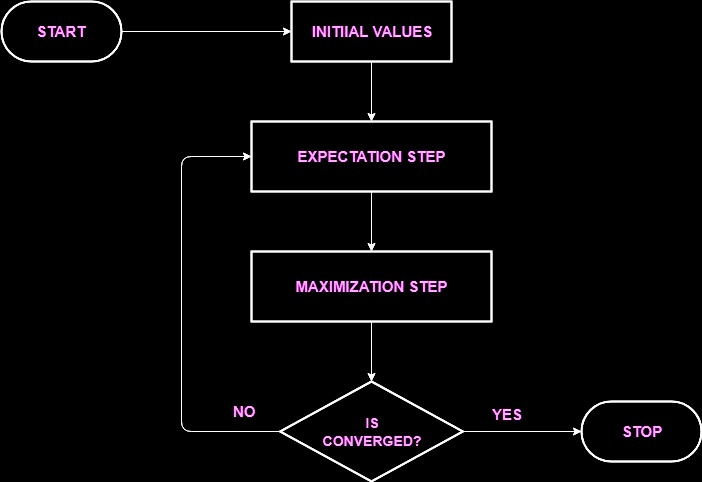

In [ ]:
Image("../resources/em_algo.jpeg")
# Source: https://www.geeksforgeeks.org/ml-expectation-maximization-algorithm

## Superresolution: localizing emitters in blurry images

+ Superresolution microscopy aims to image systems in visible light below the classical diffraction limit. This can be useful for studying chemical and biological systems (which are often probed using fluorophores that emit visible fluorescence), but similar methods have been adapted for other wavelengths and imaging modalities.
+ In superresolution microscopy, we attempt to beat the diffraction limit by localizing the emitter of individual photons. 
+ For example, if the point spread function of a point source is a Gaussian, we want to localize the emitter to the mean of the Gaussian. 


+ In some advanced superresolution methods, like PALM/STORM, only a subset of all fluorescent sources are activated at a given time, thus reducing the likelihood of two sources overlapping and thereby improving centroid localization
+ Here, we are going to work with a fluorescence microscopy image where we assume that we have a gaussian point spread function. We are going to fit the image to a mixture of Gaussians, in order to gain information about the subpixel features.


This image shows the edge of a cell's nuclear envelope, where genetic material (chromatin) has been stained in blue, nuclear pores in red, and the envelope itself in green.

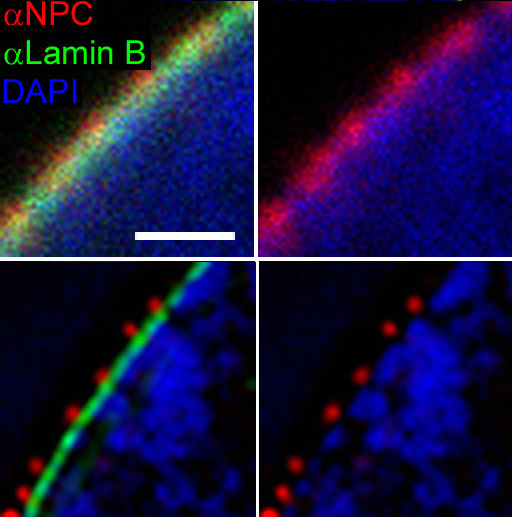

In [3]:
from PIL import Image
im_path = "../resources/wikimedia_3D-SIM-1_NPC_Confocal_vs_3D-SIM_detail.jpg"
# Open the image form working directory
im = Image.open(im_path)
im

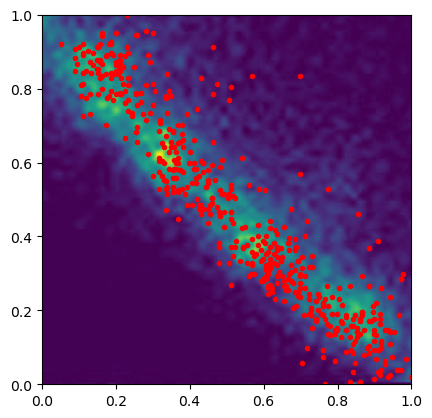

In [4]:
## Let's excerpt the red channel
im_excerpt = np.array(im)[:210, -225:-20, 0]
plt.figure()
plt.imshow(im_excerpt, extent=[0, 1, 0, 1], origin='lower')


## Sample data from the image---photons, counts, etc.
im_excerpt = im_excerpt / np.sum(im_excerpt)
im_excerpt = im_excerpt ** 2
im_excerpt = im_excerpt / np.sum(im_excerpt)
np.random.seed(0)
index = np.random.choice(np.prod(im_excerpt.shape), size=500, p=im_excerpt.ravel())
X = np.array(np.unravel_index(index, shape=im_excerpt.shape)).T.astype(float)
X /= X.max(axis=0) # scale to unit square

plt.plot(X[:, 0], X[:, 1], '.r')

# ## Let's try to fit a Gaussian mixture model to this data
# from sklearn.mixture import GaussianMixture
# gmm = GaussianMixture(n_components=4, covariance_type='full')
# gmm.fit(X)

# ## Let's plot the results
# plt.plot(gmm.means_[:, 0], gmm.means_[:, 1], '*w', markersize=20)

In [ ]:
from scipy.stats import multivariate_normal

class GaussianMixtureModel:
    """
    An implementation of the EM algorithm for Gaussian mixture models.

    Attributes:
        n_components (int): The number of mixture components.
        n_iter (int): The number of EM iterations to perform.
        tol (float): The convergence threshold. EM iterations will stop when the
            log likelihood average gain is below this threshold.
        store_history (bool): Whether or not to store the history of the means
            at each step.
        learning_rate (float): The learning rate for the gradient descent update.
        random_state (int): The random seed.

    """

    def __init__(self, n_components, n_iter=100, tol=1e-6, store_history=False, 
                    learning_rate=1.0, random_state=None
                ):
        self.n_components = n_components
        self.n_iter = n_iter
        self.tol = tol
        self.learning_rate = learning_rate

        self.random_state = random_state

        self.store_history = store_history
        if self.store_history:
            self.history = list()
    
    ## This special method determines the output of print(GaussianMixtureModel())
    def __str__(self):
        return "GaussianMixtureModel(n_components={})".format(self.n_components)

    def initialize(self, X):
        """Initialize the GMM parameters.

        Args:
            X (array-like): Training data with shape (n_samples, n_features)
            
        Returns:
            self
        """
        n_samples, n_features = X.shape

        np.random.seed(self.random_state)

        # Initialize the weights to equal
        self.weights = np.ones(self.n_components) / self.n_components

        # Initialize the means randomly from the data
        self.means = np.random.choice(X.flatten(), size=(self.n_components, n_features))
        #self.means = np.random.random(size=(self.n_components, n_features)) * np.ptp(X, axis=0)

        # Initialize the covariances
        self.covariances = np.zeros((self.n_components, n_features, n_features))
        for k in range(self.n_components):
            self.covariances[k] = np.diag(np.random.rand(n_features))

        return self

    def pdf(self, X):
        """Compute the probability density function for each sample in X.

        Args:
            X (array-like): Training data with shape (n_samples, n_features)

        Returns:
            pdf (array-like): Probability density function for each sample in X.
        """
        n_samples, n_features = X.shape

        pdf = np.zeros((n_samples, self.n_components))
        for k in range(self.n_components):
            pdf[:, k] = self.weights[k] * multivariate_normal.pdf(X, self.means[k], self.covariances[k])

        return pdf

    def expectation(self, X):
        """Perform the expectation step.

        Args:
            X (array-like): Training data with shape (n_samples, n_features)

        Returns:
            responsibilities (array-like): The responsibilities for each sample in X.
        """
        pdf = self.pdf(X)
        responsibilities = pdf / pdf.sum(axis=1, keepdims=True)

        return responsibilities

    def maximization(self, X, responsibilities):
        """Perform the maximization step.

        Args:
            X (array-like): Training data with shape (n_samples, n_features)
            responsibilities (array-like): The responsibilities for each sample in X.
                
        Returns:
            self
        """
        n_samples, n_features = X.shape

        # Update the weights
        self.weights = responsibilities.sum(axis=0) / n_samples

        # Update the means
        self.means = (1 - self.learning_rate) * self.means + self.learning_rate * np.dot(responsibilities.T, X) / responsibilities.sum(axis=0, keepdims=True).T

        #self.means_new = (1 - beta) * self.means_old + beta * self.means_new

        # Update the covariances
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.covariances[k] = (1 - self.learning_rate) * self.covariances[k] + self.learning_rate * np.dot(responsibilities[:, k] * diff.T, diff) / responsibilities[:, k].sum()

        return self

    def fit(self, X):
        """Fit the model to the data X.

        Args:
            X (array-like): Training data with shape (n_samples, n_features)

        Returns:
            self
        """
        self.initialize(X)

        for i in range(self.n_iter):
            # Expectation step
            responsibilities = self.expectation(X)

            # Maximization step
            self.maximization(X, responsibilities)

            # store the history
            if self.store_history:
                self.history.append(self.means.copy())

        return self

    def predict(self, X):
        """Predict the labels for X.

        Args:
            X (array-like): Training data with shape (n_samples, n_features)

        Returns:
            labels (array-like): The predicted labels for each sample in X.
        """
        return self.expectation(X).argmax(axis=1)






/Users/william/miniconda3/envs/cphy/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


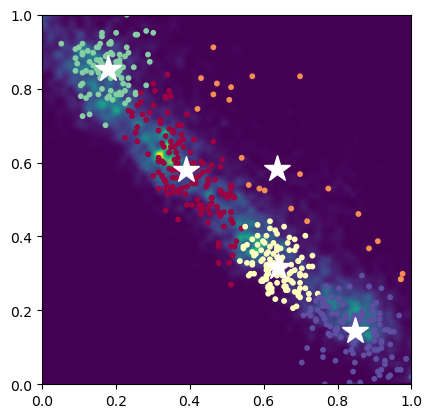

In [ ]:
gmm = GaussianMixtureModel(n_components=5, n_iter=2000, learning_rate=0.5, store_history=True, random_state=0)
gmm.fit(X)
labels = gmm.predict(X)

plt.imshow(im_excerpt, extent=[0, 1, 0, 1], origin='lower')
cmap = plt.cm.get_cmap('Spectral')
clrs = cmap(labels / np.max(labels))
plt.scatter(X[:, 0], X[:, 1], c=clrs, s=10)

# Plot centroids
plt.plot(gmm.means[:, 0], gmm.means[:, 1], '*w', markersize=20)

In [ ]:
%matplotlib inline
import numpy as np
import scipy.signal
import matplotlib.pylab as plt
import matplotlib.animation
import IPython.display

def update(i):
    # global A, img
    # U = scipy.signal.convolve2d(A, K, mode='same', boundary='wrap')
    # A = np.clip(A + 1/T * growth(U), 0, 1)
    # img.set_array(A)
    # return img,
    return im_excerpt
# figure_asset(K, growth, bar_K=True)
# fig = figure_world(A)
fig = plt.figure(figsize=(6, 6))
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=200, interval=20).to_jshtml())

<Figure size 600x600 with 0 Axes>

In [ ]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def plotter(i):
    # plt.close()
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(im_excerpt, extent=[0, 1, 0, 1], origin='lower')
    plt.plot(gmm.history[i][:, 0], gmm.history[i][:, 1], '*w', markersize=20)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()


interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(gmm.history) - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=1999), Output()), …

<function __main__.plotter(i)>

# Super-resolution microscopy: PALM and STORM

Several superresolution methods localize the fluorescent emitter by exploiting temporal information---for example, if each emission site only intermittently releases photons, we can isolate overlapping emitters based on the timing of the photons.

### Stages of a PALM/STORM experiment

1. Stochastic Activation: A sparse subset of fluorophores (fluorescent molecules) is activated to a fluorescent state, ensuring that the activated fluorophores are well-separated and do not overlap within the diffraction-limited area.

2. Localization: The point spread function (PSF) of each activated fluorophore is acquired, often appearing as a diffraction-limited spot. A mathematical fit, commonly a 2D Gaussian, is used to find the center of the PSF, allowing the fluorophore's position to be determined with high precision.

3. Deactivation: After localization, the activated fluorophores are photobleached or switched back to a dark state, making them inactive.

4. Iteration: Steps 1-3 are repeated thousands to millions of times to build a dataset of highly precise fluorophore positions.

5. Reconstruction: The super-resolution image is reconstructed from the localized positions.

PALM typically uses photo-activatable or photo-switchable fluorescent proteins. Activation is generally irreversible, leading to photobleaching over long periods. In contrast, STORM employs synthetic dyes that can be cycled between dark and bright states multiple times, thus being more reusable compared to the fluorophores used in PALM.

These approaches can achieve resolutions on the order of 20-50 nm far beyond the visible diffraction limit (~200-300 nm). This technique was one of the ones honored by the 2014 Nobel Prize in Chemistry in 2014.

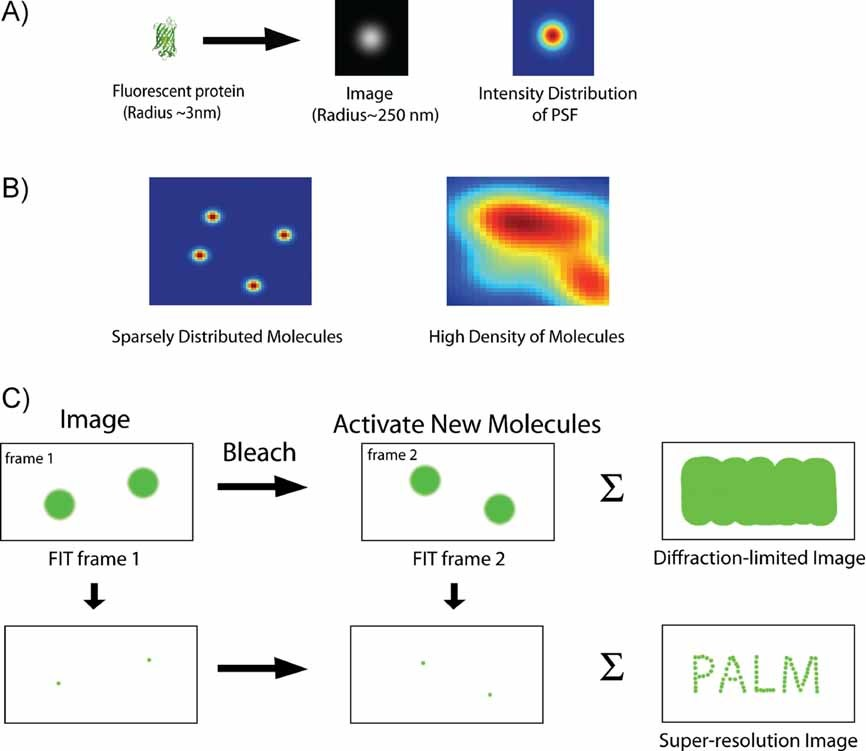

In [ ]:
Image("../resources/palm_storm.jpg", width=750)
# Sengupta & Lippincott-Schwartz, Bioessays 2012
# https://doi.org/10.1002/bies.201200022

In [ ]:
# show movie in notebook
fpath = "../resources/storm_superresolution.mp4"

from IPython.display import HTML
from base64 import b64encode
mp4 = open(fpath,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
        <source src="%s" type="video/mp4">
</video>
""" % data_url)


## Glial cell microscopy data

To demonstrate EM methods for supperresolution data, we will examine a dataset of Glial cells from in the rat hippocampus. Glial cells are the "glue" of the nervous system---they provide structural support for neurons, and also provide nutrients and manage cerebrospinal fluid. The cells in the image have been stained with phalloidin, which causes actin within the cells to fluoresce. Because actin is often used in structural support, this allows us to see the shape of the cells. The cells were imaged using dSTORM

Our demonstration dataset will be a time series of images of glial cells. This dataset was produced and made available by Christophe Leterrier and Romain F. Laine, and the full dataset is available on [Zenodo](https://zenodo.org/record/3959089). The dataset is a downsampled version of the file `BIN10_glia_actin_2D.tif` by the original authors.

In [2]:
import matplotlib.animation
import IPython.display

# get the data
# im_subset = np.load("../resources/glial_cells.npy")
im_subset = np.load("../resources/glial_cells2.npy")

# def update(i):
#     return im_subset[i]

# fig = plt.figure(figsize=(6, 6))
# IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=len(im_subset), interval=20).to_jshtml())

cplot.sliderplot(im_subset);
plt.show()



interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='100%'), max=598), Output()), _d…

In [4]:

def gmm_mle_em_2d(data, n_components=1, max_iter=100, tol=1e-3, verbose=False):
    """
    Perform subpixel localization using Gaussian Mixture Model with maximum likelihood
    estimation and expectation maximization.

    Args:
        data (ndarray): the data to fit
        n_components (int): the number of components to fit
        max_iter (int): the maximum number of iterations
        tol (float): the tolerance
        verbose (bool): whether to print the log likelihood at each iteration

    Returns:
        centers (ndarray): the centers of the fitted components
        covariances (ndarray): the covariances of the fitted components
        weights (ndarray): the weights of the fitted components

    """
    gmm = GaussianMixture(
        n_components=n_components, max_iter=max_iter, tol=tol, verbose=verbose
    )
    gmm.fit(data)
    centers = gmm.means_
    covariances = gmm.covariances_
    weights = gmm.weights_
    return centers, covariances, weights

def gaussian_bump(X, width=1):
    return np.exp(-np.sum((X / width) ** 2, axis=1))


def gaussian2d_mixture(centers, sigmas, size):
    """
    Generate a 2D Gaussian mixture with given set of centers and sigmas on an array of
     size `size`.
    """
    # check if scalar
    if np.isscalar(sigmas):
        sigmas = sigmas * np.ones(centers.shape[0])

    x = np.arange(size[0])
    y = np.arange(size[1])
    X, Y = np.meshgrid(x, y)

    # convert X, Y to a list of points in 2d
    X = np.array([Y.ravel(), X.ravel()]).T
    out = gaussian_bump(X[..., None] - centers.T[None, :], width=sigmas)
    return np.sum(out, axis=1).reshape(size)

In [5]:
# perform subpixel localization using Gaussian Mixture Model
# using maximum likelihood estimation and expectation maximization

import numpy as np
from sklearn.mixture import GaussianMixture

reconstruction_history = list()
upsample_factor = 2
reconstructed_image = np.zeros(upsample_factor * np.array(im_subset[0].shape))
for i, im in enumerate(im_subset):
    if i % (im_subset.shape[0] // 25) == 0:
        print(i, flush=True)

    ## Create candidate locations fluorophores based on local maxima
    thresh = np.percentile(im, 80)
    peaks = np.array(np.where(im > thresh)).T

    ## Refine and group peaks by fitting a Gaussian mixture model
    peaks, covariances, weights = gmm_mle_em_2d(peaks, n_components=peaks.shape[0])

    # reconstructed_image[peaks[:, 0], peaks[:, 1]] += 1
    reconstructed_image += gaussian2d_mixture(
        upsample_factor * peaks, 1, np.array(reconstructed_image.shape)
    )

    reconstruction_history.append(reconstructed_image.copy())


0
23
46
69
92
115
138
161
184
207
230
253
276
299
322
345
368
391
414
437
460
483
506
529
552
575
598


## Examine our results

We compare the output to the simple mean of the image stack, which approximates what we would expect to see if we just took a long-exposure diffraction-limited image of the cell population. Technically our superresolution image upsampled the original image 2x; however, in order to faciliate comparison we downsample it back to the original resolution in order to emphasize new information gained by the superresolution algorithm.

Text(0.5, 1.0, 'Superresolution image')

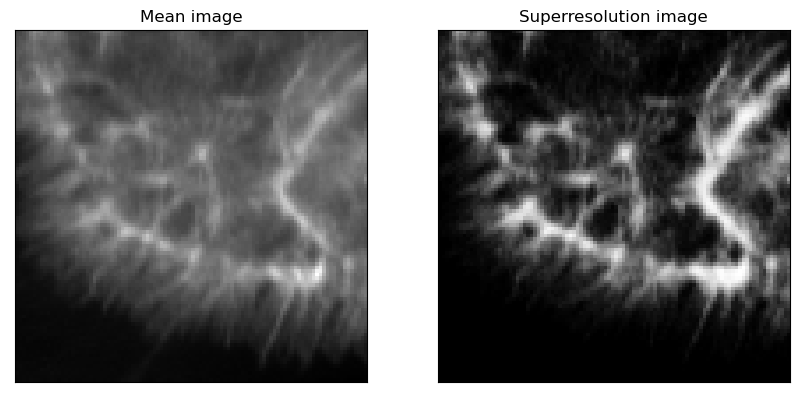

In [ ]:
minmaxscaler = lambda x : (x - np.min(x)) / (np.max(x) - np.min(x))

im_mean = np.mean(im_subset, axis=0)

# now make a single plot showing these side-by-side
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(minmaxscaler(im_mean), cmap='gray')
# hide all ticks
plt.xticks([]); plt.yticks([])
plt.title('Mean image')
plt.subplot(122)
plt.imshow(minmaxscaler(reconstructed_image)[::2, ::2], cmap='gray')
plt.xticks([]); plt.yticks([])
plt.title('Superresolution image')


In [8]:
# save the reconstruction history as a movie

frames = reconstruction_history

vmin, vmax = np.percentile(frames, 1), np.percentile(frames, 99)
for i in range(len(frames) - 1):
    
    
    out_path = "../private_dump/superresolution/frame" + str(i).zfill(4) + ".png"

    plt.figure()
    plt.imshow(frames[i],  cmap="viridis")

    ax = plt.gca()
    ax.set_axis_off()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.set_aspect(1, adjustable='box')
    cplot.vanish_axes()

    plt.savefig(out_path, bbox_inches='tight', pad_inches=0.0, dpi=300)
    plt.close() 

# Questions

+ In traditional photography, there is a well-documented tradeoff between exposure time (total light collected) and temporal resolution. What experimental parameters would you adjust to trade off between these two quantities in a superresolution experiment?

+ Suppose that whether a given fluorophore is in the on or off state is a Poisson process with rate $\lambda$. What is the probability that a given fluorophore is in the on state at time $t$? Given $N$ underlying fluorophores with the same rate $\lambda$, what is the expected number and variance of fluorophores in the on state at a given time $t$?

+ What inductive biases are present in our use of a Gaussian mixture model to model the distribution of fluorophore positions? What are the advantages and disadvantages of these biases?

